In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
# Background:
# The sinking of the Titanic is one of the most infamous shipwrecks in history.
# On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. 
# Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
# While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

# In this challenge, we ask you to build a predictive model that answers the question: 
# “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


# Import libraries:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Import data:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')


In [3]:
# Data structure:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Data structure:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
# Total no. of rows: 891 for train and 418 for test dataset.
# Cabin: data missing > 70%.
# Since data with less than 30% can’t provide meaning information, Cabin data can be deleted.
train_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)

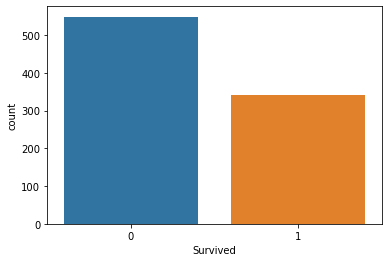

In [6]:
# Overall probability of survivial ~38%
sns.countplot(train_data.Survived)
plt.show()

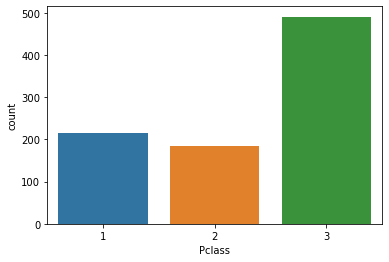

In [7]:
# Pclass
sns.countplot(train_data.Pclass)
plt.show()

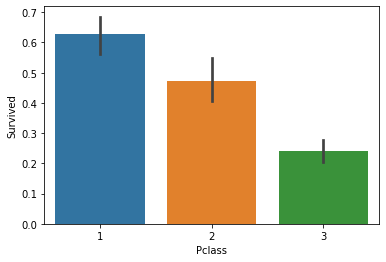

In [8]:
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.show()

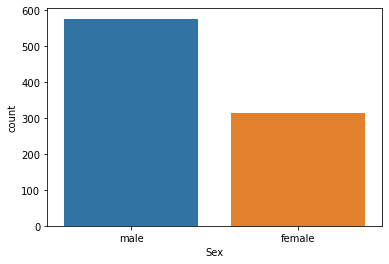

In [9]:
sns.countplot(train_data.Sex)
plt.show()

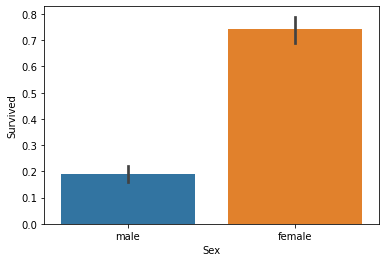

In [10]:
# 1 Passengers in Pclass 1 (Upper class) are more likely to survive.
# 2 Pclass is a good feature for prediction of survival.
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.show()

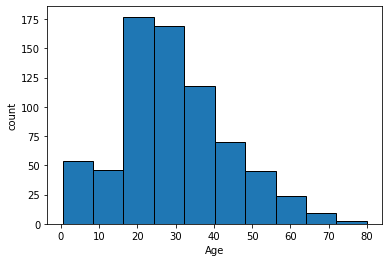

In [11]:
# 1 Proportion of male and female: ~2/3 vs ~1/3
# 2 Male is much less likely to survive, with only 20% chance of survival. For female, >70% chance of survival.
# 3 Obviously, Sex is an important feature to predict survival.
plt.hist(train_data.Age, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('count')
plt.show()

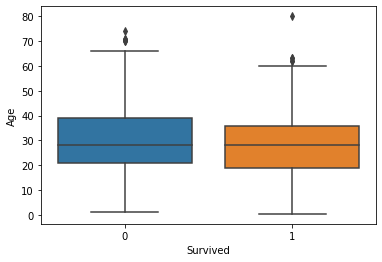

In [12]:
# Age
# 1 Passengers are mainly aged 20–40.
# 2 Younger passengers tends to survive.
sns.boxplot(x='Survived', y='Age', data=train_data)
plt.show()

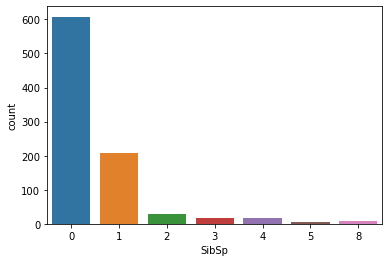

In [13]:
# SibSp
sns.countplot(train_data.SibSp)
plt.show()

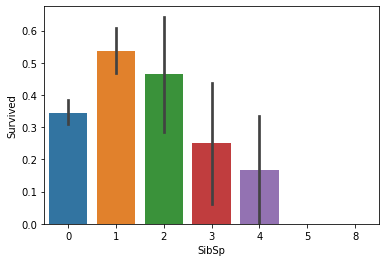

In [14]:
# 1 Most of the passengers travel with 1 sibling/spouse.
# 2 Passengers having 1 sibling/spouse are more likely to survive compared to those not.
# 3 For those more than 1 siblings/spouses, the information is insufficient to provide any insight.
sns.barplot(x='SibSp', y='Survived', data=train_data)
plt.show()

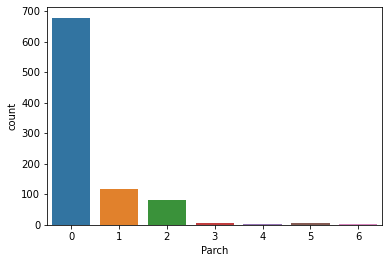

In [15]:
# Parch
sns.countplot(train_data.Parch)
plt.show()

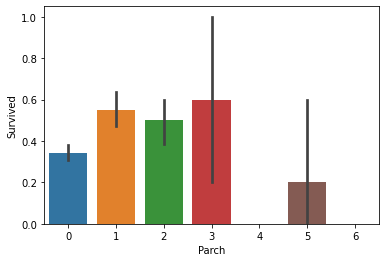

In [16]:
# 1 > 70% passengers travel without parents/children.
# 2 Passengers travelling with parents/children are more likely to survive than those not.
sns.barplot(x='Parch', y='Survived', data=train_data)
plt.show()

In [17]:
# Ticket
train_data.Ticket.head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

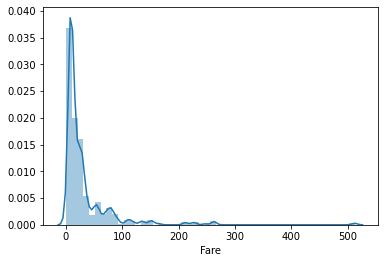

In [18]:
# Fare
sns.distplot(train_data.Fare)
plt.show()

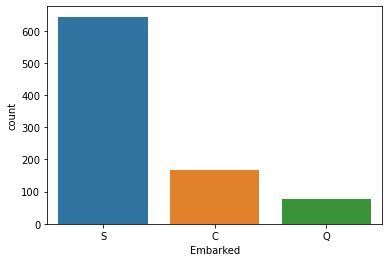

In [19]:
# Embarked
sns.countplot(train_data.Embarked)
plt.show()

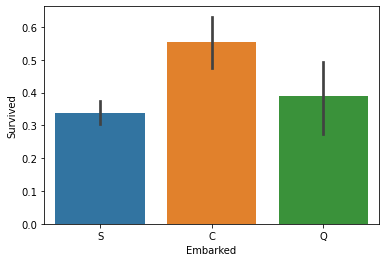

In [20]:
# 1 >2/3 passengers embarked at Port C.
# 2 Passengers embarked at Port C are more likely to survive.
sns.barplot(x='Embarked', y='Survived', data=train_data)
plt.show()

In [21]:
train_data.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [22]:
# Let’s extract the titles (Mr./Mrs./Miss/Master) from the names of passengers. 
# This can be done for both train and test datasets.

whole_data = train_data.append(test_data)
whole_data['Title'] = whole_data.Name.str.extract(r'([A-Za-z]+)\.', expand=False)
whole_data.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Countess      1
Don           1
Lady          1
Sir           1
Dona          1
Jonkheer      1
Capt          1
Mme           1
Name: Title, dtype: int64

In [23]:
# The common titles are(Mr/Miss/Mrs/Master). Some of the titles (Ms/Lady/Sir…etc.) can be grouped to the common titles. 
# The remaining unclassified titles can be frouped to “Others”.
Common_Title = ['Mr', 'Miss', 'Mrs', 'Master']
whole_data['Title'].replace(['Ms', 'Mlle', 'Mme'], 'Miss', inplace=True)
whole_data['Title'].replace(['Lady'], 'Mrs', inplace=True)
whole_data['Title'].replace(['Sir', 'Rev'], 'Mr', inplace=True)
whole_data['Title'][~whole_data.Title.isin(Common_Title)] = 'Others'

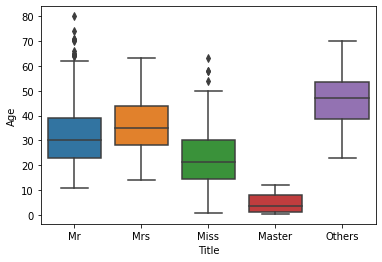

In [24]:
# Let’s look at the relationship between titiles and age in train dataset.
train_data = whole_data[:len(train_data)]
test_data = whole_data[len(train_data):]
sns.boxplot(x='Title', y='Age', data=train_data)
plt.show()

In [25]:
# Find the median of Age in each title.
# (Remarks: only use train dataset to avoid data leakage)
AgeMedian_by_titles = train_data.groupby('Title')['Age'].median()
AgeMedian_by_titles

Title
Master     3.5
Miss      21.5
Mr        30.0
Mrs       35.0
Others    47.0
Name: Age, dtype: float64

In [26]:
# Impute the missing Age values according to the titles.
for title in AgeMedian_by_titles.index:
    train_data['Age'][(train_data.Age.isnull()) & (train_data.Title == title)] = AgeMedian_by_titles[title]
    test_data['Age'][(test_data.Age.isnull()) & (test_data.Title == title)] = AgeMedian_by_titles[title]

In [27]:
# For train dataset, there are only 2 missing values. Simply impute the mode.
train_data['Embarked'].fillna(train_data.Embarked.mode()[0], inplace=True)

In [28]:
# For test dataset, there is only 1 missing value. Simply impute the median
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

In [29]:
# For train dataset, there are outliers observed. Replace them with median.
train_data.Fare.sort_values(ascending=False).head(5)

679    512.3292
258    512.3292
737    512.3292
341    263.0000
438    263.0000
Name: Fare, dtype: float64

In [30]:
train_data.loc[train_data.Fare>512, 'Fare'] = 263
train_data.Fare.sort_values(ascending=False).head(5)

341    263.0
438    263.0
88     263.0
679    263.0
258    263.0
Name: Fare, dtype: float64

In [31]:
# Check for missing data.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    float64
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Title        891 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 130.5+ KB


In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     0 non-null      float64
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          418 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         418 non-null    float64
 10  Embarked     418 non-null    object 
 11  Title        418 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 42.5+ KB


In [33]:
# Sex
train_data['Sex_Code'] = train_data['Sex'].map({'female':1, 'male':0}).astype('int')
test_data['Sex_Code'] = test_data['Sex'].map({'female':1, 'male':0}).astype('int')

In [34]:
# Embarked
train_data['Embarked_Code'] = train_data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')
test_data['Embarked_Code'] = test_data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')
# Group data into bins to make the model more robust and avoid over-fitting.

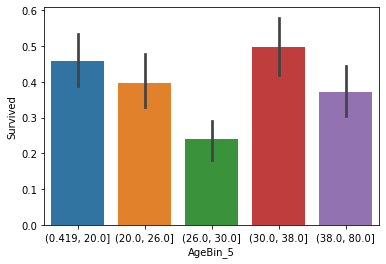

In [35]:
# Age
train_data['AgeBin_5'] = pd.qcut(train_data['Age'], 5)
test_data['AgeBin_5'] = pd.qcut(test_data['Age'], 5)
sns.barplot(x='AgeBin_5', y='Survived', data=train_data)
plt.show()

In [36]:
train_data['FareBin_5'] = pd.qcut(train_data['Fare'], 5)
test_data['FareBin_5'] = pd.qcut(test_data['Fare'], 5)

In [37]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Encode the Age and Fare bins into numbers for modelling.
label = LabelEncoder()
train_data['AgeBin_Code_5'] = label.fit_transform(train_data['AgeBin_5'])
test_data['AgeBin_Code_5'] = label.fit_transform(test_data['AgeBin_5'])

label = LabelEncoder()
train_data['FareBin_Code_5'] = label.fit_transform(train_data['FareBin_5'])
test_data['FareBin_Code_5'] = label.fit_transform(test_data['FareBin_5'])

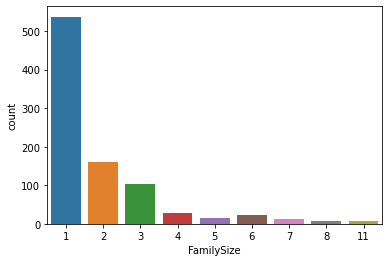

In [38]:
# Feature Creation
# SibSp and Parch are both related to family members. 
# for simple sake, I decided to combined them into a single feature namely FamilySize.
train_data['FamilySize'] = train_data.SibSp + train_data.Parch + 1
test_data['FamilySize'] = test_data.SibSp + test_data.Parch + 1
sns.countplot(train_data.FamilySize)
plt.show()

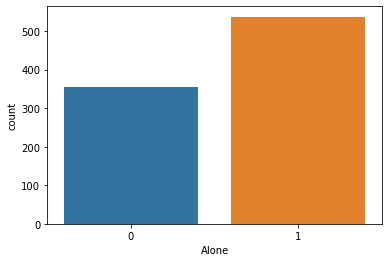

In [39]:
# Since the proportion of FamilySize=1 is dominant, it may not provide sufficeint predictive power. 
# I decided to group them and convert to travelling alone or not.
train_data['Alone'] = train_data.FamilySize.map(lambda x: 1 if x == 1 else 0)
test_data['Alone'] = test_data.FamilySize.map(lambda x: 1 if x == 1 else 0)
sns.countplot(train_data.Alone)
plt.show()

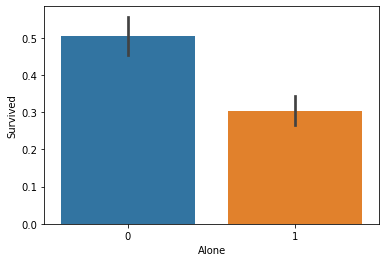

In [40]:
sns.barplot(x='Alone', y='Survived', data=train_data)
plt.show()
# It is observed that travelling alone is less likely to survive (~30% vs ~50%).

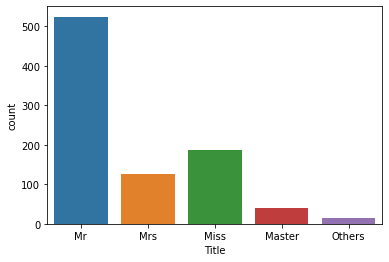

In [41]:
# Title is created for the imputation missing values of Age. It can also be used as a new features.
sns.countplot(train_data.Title)
plt.show()

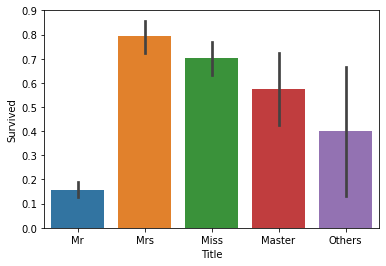

In [42]:
sns.barplot(x='Title', y='Survived', data=train_data)
plt.show()
# It is obviously that Title Mr. is much less likely to survive compared to others.

In [43]:
# Let’s encode the features for modelling
train_data['Title_Code'] = train_data.Title.map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Others':4}).astype('int')
test_data['Title_Code'] = test_data.Title.map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Others':4}).astype('int')

In [44]:
# From the Titanic movie, those survived were often in family groups. 
# They helped each other to find way out. In addition, 
# families usually have children which are the first priority to sent to safe boats. Of course, 
# there should be parents to take care of their children.
# To find out family groups, apart from surnames of passenges (there may be same surnames but different families), let’s also look at Ticket.
train_data[['Name', 'Ticket']].sort_values('Name').head(20)

,Name,Ticket
845,"Abbing, Mr. Anthony",C.A. 5547
746,"Abbott, Mr. Rossmore Edward",C.A. 2673
279,"Abbott, Mrs. Stanton (Rosa Hunt)",C.A. 2673
308,"Abelson, Mr. Samuel",P/PP 3381
874,"Abelson, Mrs. Samuel (Hannah Wizosky)",P/PP 3381
365,"Adahl, Mr. Mauritz Nils Martin",C 7076
401,"Adams, Mr. John",341826
40,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",7546
855,"Aks, Mrs. Sam (Leah Rosen)",392091
207,"Albimona, Mr. Nassef Cassem",2699


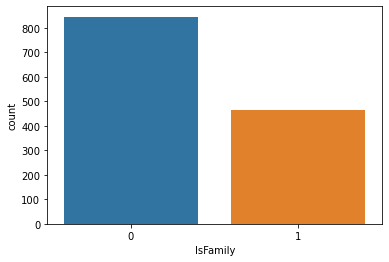

In [45]:
# It appears that passengers with same surnames have the same Ticket names.
# Let’s extract the surnames and tickets name and find out duplicate ones. 
# There may be passengers in train and test dataset from the same families. So, I decided to do it as a whole.
# To find out family groups, apart from surnames of passenges (there may be same surnames but different families), let’s also look at Ticket.
whole_data = train_data.append(test_data)
whole_data['Surname'] = whole_data.Name.str.extract(r'([A-Za-z]+),', expand=False)
whole_data['TixPref'] = whole_data.Ticket.str.extract(r'(.*\d)', expand=False)
whole_data['SurTix'] = whole_data['Surname'] + whole_data['TixPref']
whole_data['IsFamily'] = whole_data.SurTix.duplicated(keep=False)*1
sns.countplot(whole_data.IsFamily)
plt.show()

In [46]:
# Around 1/3 of the passengers are travelling with families.
# Next, let’s dig out the families with children. Simply list out those ‘SurTix’ being families and having children.
# Next, let’s dig out the families with children. Simply list out those ‘SurTix’ being families and having children.
whole_data['Child'] = whole_data.Age.map(lambda x: 1 if x <=16 else 0)
FamilyWithChild = whole_data[(whole_data.IsFamily==1)&(whole_data.Child==1)]['SurTix'].unique()
len(FamilyWithChild)

66

In [47]:
# There are 66 families which have 1 or more children.
# Encode each family with children (i.e. Assign 0 for others).
whole_data['FamilyId'] = 0
x = 1
for tix in FamilyWithChild:
 whole_data.loc[whole_data.SurTix==tix, ['FamilyId']] = x
 x += 1

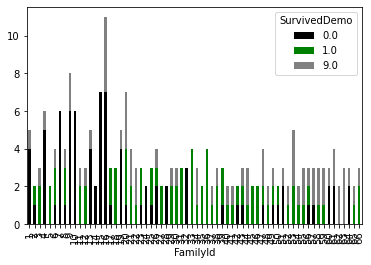

In [48]:
# let’s look at the survival data of each families with children
whole_data['SurvivedDemo'] = whole_data['Survived'].fillna(9)
pd.crosstab(whole_data.FamilyId, whole_data.SurvivedDemo).drop([0]).plot(kind='bar', stacked=True, color=['black','g','grey'])
plt.show()
# It is observed that the families are usually all survived (i.e. all green) or not survived (i.e. all black). 
# This finding proves the concept of connected survival. 
# For each family of above, if there is at least one survived, we assume the others can survive too.

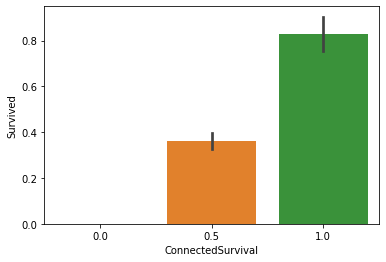

In [49]:
whole_data['ConnectedSurvival'] = 0.5 
Survived_by_FamilyId = whole_data.groupby('FamilyId').Survived.sum()
for i in range(1, len(FamilyWithChild)+1):
    if Survived_by_FamilyId[i] >= 1:
        whole_data.loc[whole_data.FamilyId==i, ['ConnectedSurvival']] = 1       
    elif Survived_by_FamilyId[i] == 0:
        whole_data.loc[whole_data.FamilyId==i, ['ConnectedSurvival']] = 0
train_data = whole_data[:len(train_data)]
test_data = whole_data[len(train_data):]
sns.barplot(x='ConnectedSurvival', y='Survived', data=train_data)
plt.show()
# The probability of survival is much higher for the passengers which:
# 1 Travelling with family member
# 2 Having 1 or more children in the family
# 3 Having 1 or more survivor in the family

In [50]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Sex_Code',
       'Embarked_Code', 'AgeBin_5', 'FareBin_5', 'AgeBin_Code_5',
       'FareBin_Code_5', 'FamilySize', 'Alone', 'Title_Code', 'Surname',
       'TixPref', 'SurTix', 'IsFamily', 'Child', 'FamilyId', 'SurvivedDemo',
       'ConnectedSurvival'],
      dtype='object')

In [51]:
# First, drop those unused columns
X_train = train_data.drop(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'AgeBin_5', 'FareBin_5', 'FamilySize', 'Surname', 'TixPref', 'SurTix', 'IsFamily', 'Child', 'FamilyId'], axis=1)
y_train = train_data['Survived']

In [52]:
# Create a variable based on the RandomForestClassifier class
model = RandomForestClassifier(n_estimators=200, random_state=2)

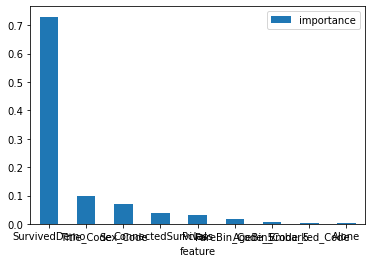

In [53]:
# Let’s look at the feature importance.
model.fit(X_train,y_train)
importance = pd.DataFrame({'feature':X_train.columns, 'importance': np.round(model.feature_importances_,3)})
importance = importance.sort_values('importance', ascending=False).set_index('feature')


importance.plot(kind='bar', rot=0)
plt.show()

In [54]:
# Choose the top 5 important features for modelling (i.e. Title_Code, Sex_Code, Connected_Survivial, Pclass and FareBin_Code_5). 
# Always keep minimal number of features to avoid over-fitting.
final = ['Title_Code', 'Sex_Code', 'ConnectedSurvival', 'Pclass', 'FareBin_Code_5']

In [55]:
# Tune model parameters.
grid_param = {
 'n_estimators': [100, 200, 300],
 'criterion':['gini', 'entropy'],
 'min_samples_split': [2, 10, 20],
 'min_samples_leaf': [1, 5],
 'bootstrap': [True, False],
}
gd_sr = GridSearchCV(estimator=model,
 param_grid=grid_param,
 scoring='accuracy',
 cv=5,
 n_jobs=-1)
gd_sr.fit(X_train[final], y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'bootstrap': True, 'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [56]:
# Set the model paramters after tunning.
model = RandomForestClassifier(n_estimators=300, bootstrap=True, criterion= 'entropy', min_samples_leaf=5, min_samples_split=2, random_state=2)

In [57]:
# Calculate the accuracy of prediction using 5-fold cross-validation.
all_accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
all_accuracies
all_accuracies.mean()

1.0

In [58]:
X_test = test_data[final]
model.fit(X_train[final],y_train)
prediction = model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction.astype(int)})
output.to_csv('Titanic submission.csv', index=False)

In [59]:
pd.options.display.max_rows = 418
output.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
